Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
%cd /content/drive/MyDrive/graphsc_dir/graphsc/notebooks

/content/drive/.shortcut-targets-by-id/1VHZIPFmOd_-Z3PGgavB9LVwCskoD0_-v/graphsc_dir/graphsc/notebooks


In [4]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 24.0 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [4]:
!pip install scanpy.api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scanpy.api (from versions: none)
ERROR: No matching distribution found for scanpy.api


In [26]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, 
                             silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score)
from sklearn.cluster import KMeans
from sklearn import metrics
import dgl
import torch
import torch.nn as nn
import copy
from tqdm.notebook import tqdm
import models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering, MeanShift
from sklearn.cluster import AgglomerativeClustering, Birch
from sklearn import mixture
import h5py
import scipy as sp
# import scanpy.api as sc
from collections import Counter
import random

import pickle
import seaborn as sns
import train
import time
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
!pip uninstall leidenalg

Found existing installation: leidenalg 0.9.1
Uninstalling leidenalg-0.9.1:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/leidenalg-0.9.1.dist-info/*
    /usr/local/lib/python3.8/dist-packages/leidenalg.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.8/dist-packages/leidenalg/*
Proceed (Y/n)? y
  Successfully uninstalled leidenalg-0.9.1


In [55]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = train.get_device()
category = "real_data"

epochs = 10
batch_size = 128
pca_size = 50
path = "../R/results/"
files = glob2.glob(f'{path}real_data/*.h5')
print(files)
files = [f[len(f"'{path}real_data"):-3] for f in files]
print(files)


['../R/results/real_data/Quake_Smart-seq2_Trachea.h5']
['Quake_Smart-seq2_Trachea']


In [56]:
results = pd.DataFrame()
model_name = "GraphConv"
normalize_weights = "log_per_cell"
node_features = "scale"
same_edge_values = False
edge_norm = True
hidden_relu = False
hidden_bn = False
n_layers = 1
hidden_dim = 200
hidden = [300]
nb_genes = 3000
activation = F.relu
for dataset in files:
    print(f">> {dataset}")

    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5", "r")
    

    Y = np.array(data_mat['Y'])
    X = np.array(data_mat['X'])
    cluster_number = np.unique(Y).shape[0] 


    genes_idx, cells_idx = train.filter_data(X, highly_genes=nb_genes)
    X = X[cells_idx][:, genes_idx]
    Y = Y[cells_idx]

    t0 = time.time()
    graph = train.make_graph(
        X,
        Y,
        dense_dim=pca_size,
        node_features=node_features,
        normalize_weights=normalize_weights,
    )

    labels = graph.ndata["label"]
    train_ids = np.where(labels != -1)[0]

    sampler = dgl.dataloading.MultiLayerFullNeighborSampler(n_layers)

    dataloader = dgl.dataloading.NodeDataLoader(
        graph,
        train_ids,
        sampler,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
        num_workers=1,
    )

    print(
        f"INPUT: {model_name}  {hidden_dim}, {hidden}, {same_edge_values}, {edge_norm}"
    )
    t1 = time.time()

    for run in range(3):
        t_start = time.time()
        torch.manual_seed(run)
        torch.cuda.manual_seed_all(run)
        np.random.seed(run)
        random.seed(run)

        model = models.GCNAE(
            in_feats=pca_size,
            n_hidden=hidden_dim,
            n_layers=n_layers,
            activation=activation,
            dropout=0.1,
            hidden=hidden,
            hidden_relu=hidden_relu,
            hidden_bn=hidden_bn,
        ).to(device)
        if run == 0:
            print(f">", model)

        optim = torch.optim.Adam(model.parameters(), lr=1e-5)

        scores = train.train(model, optim, epochs, dataloader, plot=False,n_clusters=cluster_number,
                            cluster=["KMeans", "Leiden"], save = True)
        scores["dataset"] = dataset
        scores["time_training"] = (scores['ae_end'] - t_start)
        scores["run"] = run

        results = results.append(scores, ignore_index = True)
        
        z = scores["features"]
        n_clusters = np.unique(Y).shape[0]
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=0)
        kmeans_pred = kmeans.fit_predict(z)

#         ari_k = round(adjusted_rand_score(Y, kmeans_pred),4)
#         print(f"ARI!!! {ari_k}, {z.shape}")

        results.to_pickle(
            f"../output/pickle_results/{category}/{category}_gae_features.pkl")
        print("Done")

>> Quake_Smart-seq2_Trachea


/usr/local/lib/python3.8/dist-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


INPUT: GraphConv  200, [300], False, True
> GCNAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (layer1): WeightedGraphConv(in=50, out=200, normalization=both, activation=<function relu at 0x7efcd60b1550>)
  (decoder): InnerProductDecoder()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
  )
)


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/dgl/dataloading/dataloader.py:859: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


ARI 0.6103, 0.4143107235431671
Done


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/dgl/dataloading/dataloader.py:859: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


ARI 0.5448, 0.40206480026245117
Done


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/dgl/dataloading/dataloader.py:859: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


ARI 0.8815, 0.4354468286037445
Done


In [57]:
results.mean()

ae_end           1.675443e+09
kmeans_ari       6.788667e-01
kmeans_nmi       7.068667e-01
kmeans_sil       4.172741e-01
kmeans_cal       4.253581e+02
kmeans_time      7.310804e-01
leiden_ari       2.618000e-01
leiden_nmi       5.631667e-01
leiden_sil       3.170294e-01
leiden_cal       3.057070e+02
leiden_time      3.651580e+00
time_training    1.986509e+01
run              1.000000e+00
dtype: float64

# Compute ARI, BIC

In [58]:
df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_gae_features.pkl")

In [59]:
r = pd.DataFrame(columns = ["dataset", "n_clust", "ari", "nmi", "bic", "aic" ])
for dataset in tqdm(files):
    print(">>", dataset)
    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5","r")
    Y = np.array(data_mat['Y'])

    cluster_number = np.unique(Y).shape[0]
    candidates = np.arange(-5, 5)
    for candidate in candidates:
        n_clust = candidate + cluster_number
        if n_clust<2:
            continue
        
        features = df[df["dataset"] == dataset]["features"].values

        for i in range(len(features)):
            embedding = features[i]
#             print(f"Embedding shape {embedding.shape}")

            gmm = mixture.GaussianMixture(n_components=n_clust, init_params='kmeans')
            gmm.fit(embedding)
            pred = gmm.predict(embedding)
            print(np.unique(pred).shape)
            ari = adjusted_rand_score(Y, pred)
            nmi = normalized_mutual_info_score(Y, pred)
            bic , aic = gmm.bic(embedding), gmm.aic(embedding)
            r.loc[r.shape[0]]=[dataset, candidate, ari, nmi, bic, aic]

  0%|          | 0/1 [00:00<?, ?it/s]

>> Quake_Smart-seq2_Trachea
(2,)
(2,)
(2,)
(3,)
(3,)
(3,)
(4,)
(4,)
(4,)
(5,)
(5,)
(5,)
(6,)
(6,)
(6,)
(7,)
(7,)
(7,)
(8,)
(8,)
(8,)


In [60]:
r.to_pickle(f"../output/pickle_results/{category}/{category}_aic_bic.pkl")

In [61]:
r.head()

,dataset,n_clust,ari,nmi,bic,aic
0,Quake_Smart-seq2_Trachea,-2,0.411118,0.540239,-1.247408e+06,-1.720808e+06
1,Quake_Smart-seq2_Trachea,-2,0.411446,0.526704,-1.250598e+06,-1.723998e+06
2,Quake_Smart-seq2_Trachea,-2,0.415649,0.539979,-1.244537e+06,-1.717937e+06
3,Quake_Smart-seq2_Trachea,-1,0.255771,0.477804,-1.121057e+06,-1.831159e+06
4,Quake_Smart-seq2_Trachea,-1,0.507530,0.550312,-1.165968e+06,-1.876070e+06


In [62]:

res = pd.DataFrame(columns = ["BIC", "AIC", "True nb clusters"])
res_clust = pd.DataFrame(columns = ["BIC", "AIC"])
for dataset, g in r.groupby("dataset"):
    bic = g.sort_values(by = "bic")["ari"].values[-1]
    n_clust_bic = g.sort_values(by = "bic")["n_clust"].values[-1]
    aic = g.sort_values(by = "aic")["ari"].values[0]
    true = g[g["n_clust"] == 0].sort_values(by = "ari")["ari"].values[-1]
    n_clust_aic = g.sort_values(by = "aic")["n_clust"].values[0]
    res.loc[res.shape[0]] = [bic, aic, true]
    res_clust.loc[res_clust.shape[0]] = [n_clust_bic, n_clust_aic]

In [63]:
r1 = pd.melt(res)
r2 = pd.melt(res_clust)

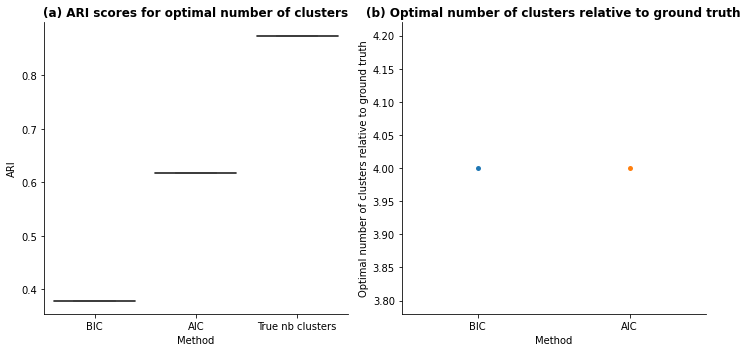

In [64]:
plt.figure(figsize = (10, 5))
ax = plt.subplot(121)
sns.boxplot(data = r1, x = "variable", y = "value")
sns.despine()
plt.ylabel("ARI")
plt.xlabel("Method")
plt.title("(a) ARI scores for optimal number of clusters", fontweight = "bold")

ax = plt.subplot(122)
sns.swarmplot(data = r2, x = "variable", y = "value")
sns.despine()
plt.xlabel("Method")
plt.ylabel("Optimal number of clusters relative to ground truth")
plt.title("(b) Optimal number of clusters relative to ground truth", fontweight = "bold")
plt.tight_layout()
plt.savefig(f"../diagrams/bic.pdf", bbox_inches='tight')

# Run other clustering algorithms

In [65]:
df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_gae_features.pkl")

In [66]:
aris = pd.DataFrame(columns= ["Dataset", "Method", "run", "score", "time"])
nmis = pd.DataFrame(columns= ["Dataset", "Method", "run", "score", "time"])
sils = pd.DataFrame(columns= ["Dataset", "Method", "run", "score", "time"])
cals = pd.DataFrame(columns= ["Dataset", "Method", "run", "score", "time"])

def add_scores(Y, pred, embedding, i, t, method="KMeans"):
    score = adjusted_rand_score(Y, pred)
    aris.loc[aris.shape[0]] = [dataset, method, i, score, t]
    score = normalized_mutual_info_score(Y, pred)
    nmis.loc[nmis.shape[0]] = [dataset, method, i, score, t]
    score = silhouette_score(embedding, pred)
    sils.loc[sils.shape[0]] = [dataset, method, i, score, t]
    score = calinski_harabasz_score(embedding, pred)
    cals.loc[cals.shape[0]] = [dataset, method, i, score, t]

In [69]:
import train
for dataset in files:
    print(">>", dataset)
    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5","r")
    Y = np.array(data_mat['Y'])

    cluster_number = np.unique(Y).shape[0]

    features = df[df["dataset"] == dataset]["features"].values

    for i in range(len(features)):


        embedding = features[i]
        print(f"Embedding shape {embedding.shape}")
        
        t0 = time.time()
        kmeans = KMeans(n_clusters=cluster_number,
                        init="k-means++",
                        random_state=5)
        pred = kmeans.fit_predict(embedding)
        t = time.time() -t0
        add_scores(Y, pred, embedding, i, t, method="KMeans")
        
        
        t0 = time.time()
        gmm = mixture.GaussianMixture(n_components=cluster_number)
        gmm.fit(embedding)
        pred = gmm.predict(embedding)
        t = time.time() -t0
        add_scores(Y, pred, embedding, i, t, method="GMM")
        print(".")
        
        
        embedding = PCA(n_components = 50).fit_transform(embedding)
        print(".", embedding.shape)
        t0 = time.time()
        pred = train.run_leiden(embedding)###,leiden_n_neighbors=300)
        t = time.time() -t0
        add_scores(Y, pred, embedding, i, t, method="Leiden")

        print(".")
        t0 = time.time()
        ward = AgglomerativeClustering(n_clusters=cluster_number, linkage='ward')
        ward.fit(embedding)
        pred = ward.labels_
        t = time.time() -t0
        add_scores(Y, pred, embedding, i, t, method="Ward Hierarchical Clust")
        print(".")

        t0 = time.time()
        model = Birch(n_clusters=cluster_number)
        pred = gmm.fit_predict(embedding)
        t = time.time() -t0
        add_scores(Y, pred, embedding, i, t, method="Birch")
        print(".")
        t0 = time.time()
        ms = MeanShift()
        ms.fit(embedding)
        pred = ms.labels_
        t = time.time() -t0
        add_scores(Y, pred, embedding, i, t, method="Mean Shift")
        print("##")

>> Quake_Smart-seq2_Trachea
Embedding shape (1350, 300)
.
. (1350, 50)
.
.
.
##
Embedding shape (1350, 300)
.
. (1350, 50)
.
.
.
##
Embedding shape (1350, 300)
.
. (1350, 50)
.
.
.
##


In [70]:
aris.to_pickle(f"../output/pickle_results/{category}/{category}_compare_aris.pkl")

nmis.to_pickle(f"../output/pickle_results/{category}/{category}_compare_nmis.pkl")

sils.to_pickle(f"../output/pickle_results/{category}/{category}_compare_sils.pkl")

cals.to_pickle(f"../output/pickle_results/{category}/{category}_compare_cals.pkl")

In [71]:
aris= pd.read_pickle(f"../output/pickle_results/{category}/{category}_compare_aris.pkl")

nmis= pd.read_pickle(f"../output/pickle_results/{category}/{category}_compare_nmis.pkl")

sils= pd.read_pickle(f"../output/pickle_results/{category}/{category}_compare_sils.pkl")

cals= pd.read_pickle(f"../output/pickle_results/{category}/{category}_compare_cals.pkl")

In [72]:
nmis.groupby("Method")["time"].mean()

Method
Birch                       0.304938
GMM                         0.794294
KMeans                      1.029390
Leiden                      2.799353
Mean Shift                 13.125731
Ward Hierarchical Clust     0.114433
Name: time, dtype: float64

In [73]:
nmis.groupby("Method")["time"].mean()/0.396875

Method
Birch                       0.768347
GMM                         2.001370
KMeans                      2.593740
Leiden                      7.053487
Mean Shift                 33.072709
Ward Hierarchical Clust     0.288335
Name: time, dtype: float64

In [74]:
datasets = [
    'Quake_Smart-seq2_Trachea',
    'Quake_10x_Bladder',
    'Quake_10x_Spleen',
    'Quake_Smart-seq2_Diaphragm',
    'Quake_10x_Limb_Muscle',
    'Quake_Smart-seq2_Limb_Muscle',
    'Romanov',
    'Adam',
    'Muraro',
    'Young',
    'Quake_Smart-seq2_Lung',
    '10X_PBMC',
    'mouse_ES_cell',
    'worm_neuron_cell',
    'mouse_bladder_cell',
]

ordered_datasets = dict(zip(datasets, np.arange(len(datasets))))

In [75]:
aris = aris.groupby(["Dataset", "Method"])["score"].mean().unstack("Method")[[
    'KMeans', 'Leiden', 'Birch', 'GMM', 'Mean Shift', #'Spectral Clust',
    'Ward Hierarchical Clust'
]].round(2).reset_index()

aris["ordered_dataset"] = aris["Dataset"].apply(lambda x: ordered_datasets[x])
aris.sort_values(by="ordered_dataset").to_excel(
    f"../output/pickle_results/{category}/{category}_compare_aris.xlsx")

In [76]:
nmis = nmis.groupby(["Dataset", "Method"])["score"].mean().unstack("Method")[[
    'KMeans', 'Leiden', 'Birch', 'GMM', 'Mean Shift', #'Spectral Clust',
    'Ward Hierarchical Clust'
]].round(2).reset_index()
nmis["ordered_dataset"] = nmis["Dataset"].apply(lambda x: ordered_datasets[x])
nmis.sort_values(by="ordered_dataset").to_excel(
    f"../output/pickle_results/{category}/{category}_compare_nmis.xlsx")

In [77]:
sils = sils.groupby(["Dataset", "Method"])["score"].mean().unstack("Method")[[
    'KMeans', 'Leiden', 'Birch', 'GMM', 'Mean Shift', #'Spectral Clust',
    'Ward Hierarchical Clust'
]].round(2).reset_index()
sils["ordered_dataset"] = sils["Dataset"].apply(lambda x: ordered_datasets[x])
sils.sort_values(by="ordered_dataset").to_excel(
    f"../output/pickle_results/{category}/{category}_compare_sils.xlsx")

In [78]:
cals = cals.groupby(["Dataset", "Method"])["score"].mean().unstack("Method")[[
    'KMeans', 'Leiden', 'Birch', 'GMM', 'Mean Shift', #'Spectral Clust',
    'Ward Hierarchical Clust'
]].round(2).reset_index()
cals["ordered_dataset"] = cals["Dataset"].apply(lambda x: ordered_datasets[x])
cals.sort_values(by="ordered_dataset").to_excel(
    f"../output/pickle_results/{category}/{category}_compare_cals.xlsx")

In [79]:
aris.mean().round(2)

Method
KMeans                     0.65
Leiden                     0.27
Birch                      0.63
GMM                        0.43
Mean Shift                 0.84
Ward Hierarchical Clust    0.66
ordered_dataset            0.00
dtype: float64

In [80]:
nmis.mean().round(2)

Method
KMeans                     0.69
Leiden                     0.57
Birch                      0.68
GMM                        0.58
Mean Shift                 0.75
Ward Hierarchical Clust    0.69
ordered_dataset            0.00
dtype: float64

In [81]:
sils.mean().round(2)

Method
KMeans                     0.42
Leiden                     0.34
Birch                      0.44
GMM                        0.35
Mean Shift                 0.48
Ward Hierarchical Clust    0.42
ordered_dataset            0.00
dtype: float64

In [82]:
cals.mean().round(2)

Method
KMeans                     425.11
Leiden                     328.24
Birch                      361.66
GMM                        361.63
Mean Shift                 117.16
Ward Hierarchical Clust    428.94
ordered_dataset              0.00
dtype: float64

In [83]:
# !pip install openpyxl